In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
import princo_ml as pml
%matplotlib inline

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from princo_ml.controllers.Controller import Controller as Control
from princo_ml.clusters.DataCluster import DataCluster as Data
from princo_ml.clusters.LearnCluster import LearnCluster as Learn
from princo_ml.clusters.MergeCluster import MergeCluster as Merge

In [3]:
from princo_ml.utils.learn_modules.learners.GradientLearner import GradientLearner
from princo_ml.utils.learn_modules.learners.NewtonLearner import NewtonLearner
from princo_ml.utils.learn_modules.learners.MomentumLearner import MomentumLearner
from princo_ml.utils.learn_modules.learners.SmoothLearner import SmoothLearner

from princo_ml.utils.learn_modules.activators.LinearActivate import LinearActivate
from princo_ml.utils.learn_modules.activators.SigmoidActivate import SigmoidActivate
from princo_ml.utils.learn_modules.activators.TanhActivator import TanhActivator
from princo_ml.utils.learn_modules.activators.ReluActivator import ReluActivator

from princo_ml.utils.learn_modules.DenseHingeModule import DenseHingeModule

In [4]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']

In [5]:
dataset.loc[np.random.choice(dataset.index, size = 100), 'bathrooms'] = np.nan

In [6]:
verbose = False

learner = SmoothLearner

learn_rate_kwargs = {
    'seed_learn': 5e-1
}

loss_kwargs = {}

nesterov = True

hinger = DenseHingeModule
hinges = 5

activator = TanhActivator
activator_kwargs = {
    #'leak': 0.1
}

batcher_kwargs = {
    'proportion': 1.0
}

control = Control(
    'regression_controller',
    loss_smooth_coefs = [0.9, 100]
)

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter_kwargs = {'verbose': verbose},
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)

control.link_add(
    Learn(
        'learn_cluster_1',
        module = hinger,
        module_kwargs = {
            'nodes': 128,
            'hinges': hinges,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1', 'input'
)

control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose,
            'nesterov': nesterov,
            'learner': learner,
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_2', 'input'
    #'data_cluster', 'input', data_cols = feature_cols
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [7]:
control.train_model(10000)

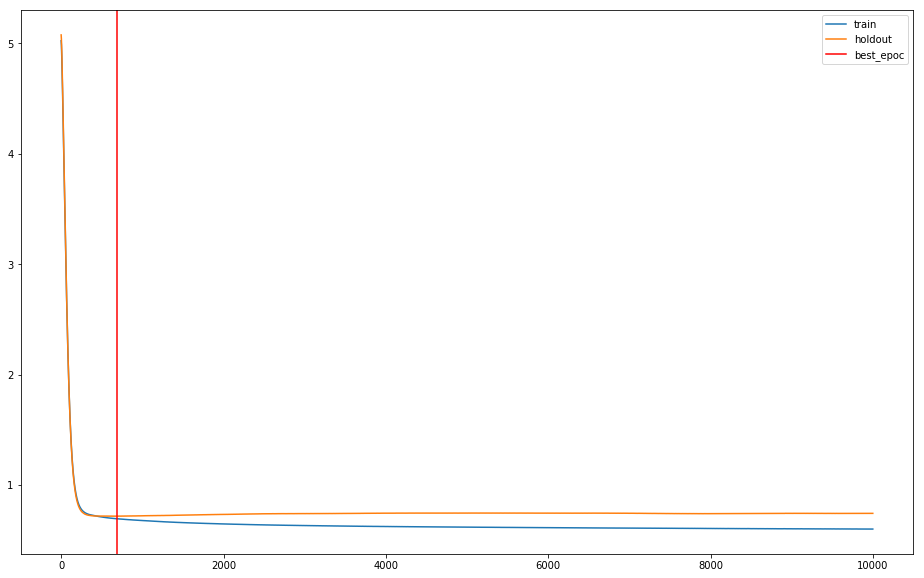

In [8]:
control.plot_losses()

In [9]:
control.clusters['learn_cluster_1'].coefs()

{'bias': tensor([ 0.0220, -0.0108,  0.0162, -0.0086,  0.0175,  0.0018, -0.0053,  0.0010,
         -0.0176, -0.0096,  0.0185, -0.0030, -0.0149,  0.0322, -0.0048, -0.0299,
         -0.0089, -0.0105, -0.0134, -0.0117, -0.0010, -0.0253,  0.0091,  0.0359,
         -0.0247,  0.0208, -0.0317, -0.0189, -0.0137,  0.0131, -0.0029,  0.0317,
          0.0163, -0.0151,  0.0416,  0.0034,  0.0038,  0.0193,  0.0130,  0.0104,
          0.0009,  0.0069, -0.0171,  0.0151,  0.0105, -0.0167, -0.0052, -0.0212,
          0.0105,  0.0101, -0.0012, -0.0016, -0.0189,  0.0204,  0.0001,  0.0144,
         -0.0042, -0.0223,  0.0150, -0.0133,  0.0108, -0.0089, -0.0042,  0.0088,
          0.0291,  0.0142,  0.0085,  0.0299, -0.0148, -0.0070,  0.0034,  0.0228,
          0.0183,  0.0003,  0.0101,  0.0135,  0.0015, -0.0150, -0.0327,  0.0003,
         -0.0019,  0.0199, -0.0153,  0.0049, -0.0110, -0.0135,  0.0058, -0.0214,
         -0.0136,  0.0121, -0.0085,  0.0005, -0.0031, -0.0030,  0.0011, -0.0201,
         -0.0081,  0